# Knee Radigoraphy images synthesis by DC GAN

In [1]:
#%matplotlib inline
from IPython.display import HTML
import argparse
import os
import random
import torch
from torch import nn, optim, tensor
from torch.nn import parallel
from torch.backends import cudnn
from torch.utils.data import DataLoader
import pandas as pd
from torchvision import datasets,transforms, utils
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from __future__ import print_function

# Set random seem for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
manualSeed = 999
grade = 2
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
%matplotlib inline

print("your grade:", grade)

Random Seed:  999
your grade: 2


In [2]:
classifier=pd.read_csv('knee_label_l.csv')

In [3]:
classifier

subject_id  barcode side  xrkl      filename
0        9400081      104    L     0  00000104.png
1        9406033      204    L     0  00000204.png
2        9421088      304    L     2  00000304.png
3        9419076      404    L     1  00000404.png
4        9429115      504    L     1  00000504.png
...          ...      ...  ...   ...           ...
4404     9113674  3159301    L     1  03159301.png
4405     9449412  3159801    L     2  03159801.png
4406     9488595  3160001    L     2  03160001.png
4407     9264200  3160201    L     2  03160201.png
4408     9594111  3160501    L     3  03160501.png

[4409 rows x 5 columns]

In [4]:
for i in range(5):
    
    PATH = f'./new_images/{i}/{i}'
    print(f'There are {len(os.listdir(PATH))} pictures of knees in grade.')

There are 1754 pictures of knees in grade.
There are 783 pictures of knees in grade.
There are 1120 pictures of knees in grade.
There are 610 pictures of knees in grade.
There are 144 pictures of knees in grade.


In [5]:
data = classifier
import seaborn as sns
#check target labels
grade_map = {0: 'grade 0', 1: 'grade 1', 2: 'grade 2', 3: 'grade 3', 4: 'grade 4'}
grade_counts = data['xrkl'].value_counts(sort=False).reset_index().sort_values(by=['xrkl'], ascending=False)
grade_counts.columns = ['xrkl', 'number']
grade_counts['xrkl'] = grade_counts['xrkl'].map(grade_map)
grade_counts


xrkl  number
0  grade 0    1753
3  grade 2    1120
2  grade 1     783
4  grade 3     610
1  grade 4     143

/home/orthoinsight/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


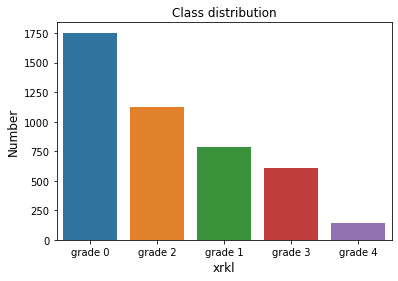

In [6]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(grade_counts.xrkl, grade_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('xrkl', fontsize=12)
plt.show()

In [7]:
# Root directory for dataset

dataroot = f"./new_images/{grade}/"

# Number of workers for dataloader
workers = 4

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 2

Data
----






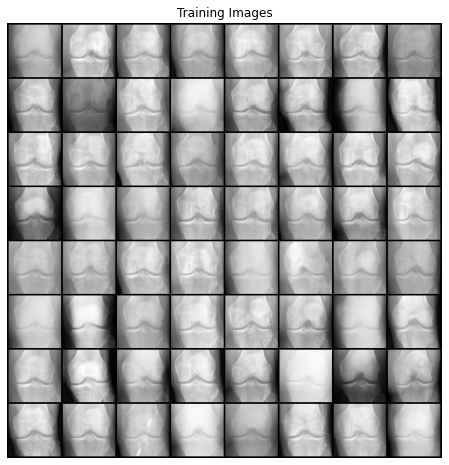

In [8]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

Implementation
--------------






In [9]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator

1. make generator network

2. After that, we can instantiate the generator and apply the `weights_init`
function. Check out the printed model to see how the generator object is
structured.



In [10]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)


print(device.type)
print(ngpu)
# Print the model
print(netG)

cuda
2
DataParallel(
  (module): Generator(
    (main): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
      (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace=True)
      (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), strid

# Discriminator Code

1. Make discriminator network

2. After that, as with the generator, we can create the discriminator, apply the
``weights_init`` function, and print the model’s structure.




In [11]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
    
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

DataParallel(
  (module): Discriminator(
    (main): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): LeakyReLU(negative_slope=0.2, inplace=True)
      (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): LeakyReLU(negative_slope=0.2, inplace=True)
      (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (10): LeakyReLU(negative_slope=0.2, inplace=True)
      (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    

# Loss Functions and Optimizers







In [12]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Training


In [13]:
# Training Loop

# Lists to keep track of progress
G_losses = []
D_losses = []
img_list = []
iters = 0
print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batc
        output=output.float()
        label =label.float()
        #print(output.shape)
        #print(label.shape)
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output,label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()
        
        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(utils.make_grid(fake, padding=0, normalize=True))
            
        iters += 1

Starting Training Loop...
[0/500][0/9]	Loss_D: 2.3856	Loss_G: 2.8987	D(x): 0.3012	D(G(z)): 0.5852 / 0.0831
[1/500][0/9]	Loss_D: 0.1964	Loss_G: 7.5642	D(x): 0.9675	D(G(z)): 0.1067 / 0.0009
[2/500][0/9]	Loss_D: 0.0438	Loss_G: 8.2587	D(x): 0.9935	D(G(z)): 0.0361 / 0.0004
[3/500][0/9]	Loss_D: 0.0660	Loss_G: 10.7286	D(x): 0.9965	D(G(z)): 0.0597 / 0.0000
[4/500][0/9]	Loss_D: 0.0055	Loss_G: 8.8255	D(x): 0.9952	D(G(z)): 0.0006 / 0.0002
[5/500][0/9]	Loss_D: 0.0309	Loss_G: 9.7856	D(x): 0.9963	D(G(z)): 0.0265 / 0.0001
[6/500][0/9]	Loss_D: 0.0215	Loss_G: 9.3215	D(x): 0.9899	D(G(z)): 0.0106 / 0.0001
[7/500][0/9]	Loss_D: 0.0165	Loss_G: 9.1671	D(x): 0.9953	D(G(z)): 0.0116 / 0.0001
[8/500][0/9]	Loss_D: 0.0140	Loss_G: 9.2326	D(x): 0.9949	D(G(z)): 0.0087 / 0.0001
[9/500][0/9]	Loss_D: 0.0113	Loss_G: 9.0374	D(x): 0.9983	D(G(z)): 0.0096 / 0.0001
[10/500][0/9]	Loss_D: 0.0114	Loss_G: 8.6885	D(x): 0.9984	D(G(z)): 0.0097 / 0.0002
[11/500][0/9]	Loss_D: 0.0075	Loss_G: 8.4421	D(x): 0.9987	D(G(z)): 0.0062 / 0.0003

Results
-------



**Loss versus training iteration**





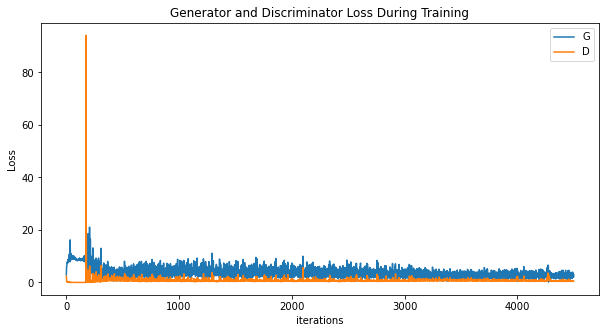

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

**Visualization of G’s progression**






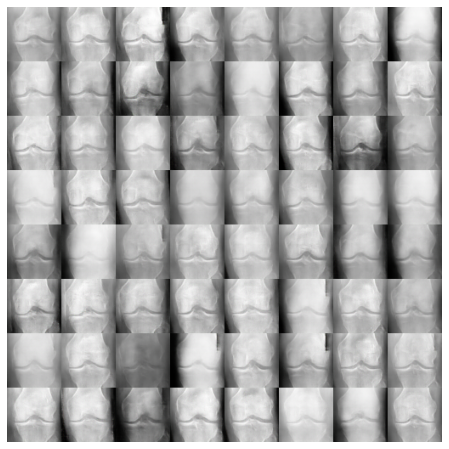

In [15]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

# **Real Images vs. Fake Images**






torch.Size([512, 512, 3])
torch.Size([512, 512, 3])


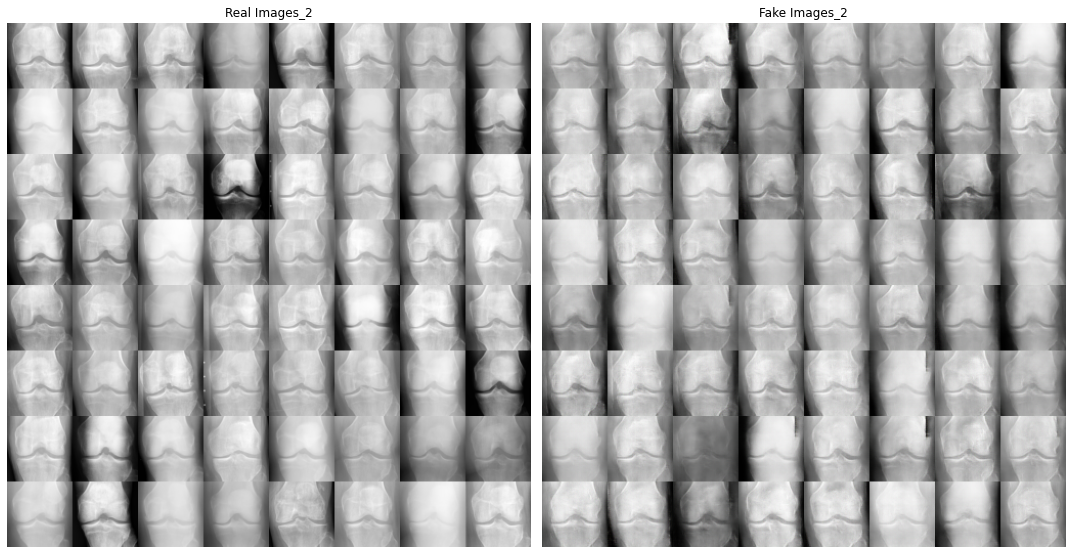

In [16]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title(f"Real Images_{grade}")
img_real = np.transpose(utils.make_grid(real_batch[0].to(device)[:64], padding=0, normalize=True).cpu(),(1,2,0))
plt.imshow(img_real)
print(img_real.shape)

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title(f"Fake Images_{grade}")
img_fake = np.transpose(img_list[-1],(1,2,0))
print(img_fake.shape)
plt.imshow(img_fake)

plt.tight_layout()
plt.savefig(f'GAN_image_knee_after{num_epochs}epoches_{grade}.png')
plt.show()



0 0


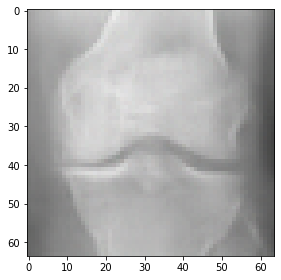

0 1


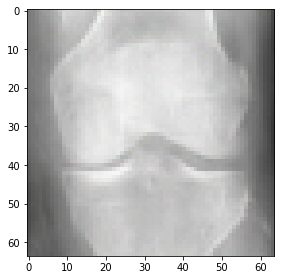

0 2


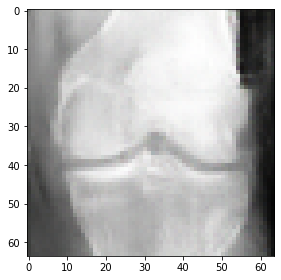

0 3


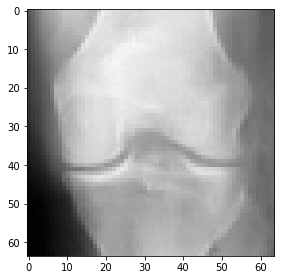

0 4


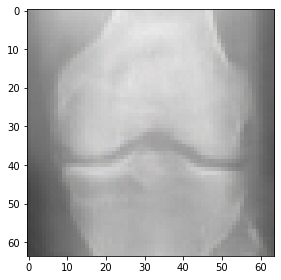

0 5


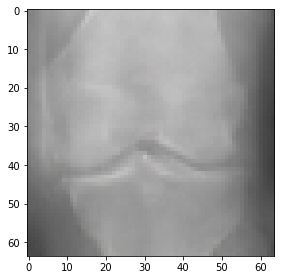

0 6


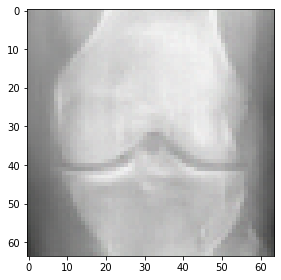

0 7


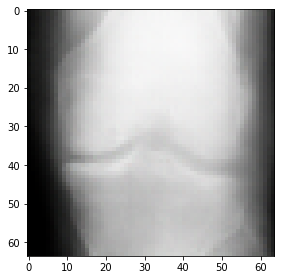

1 0


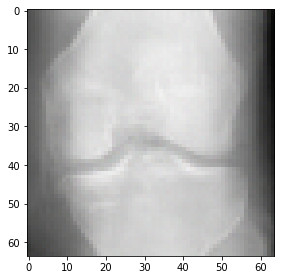

1 1


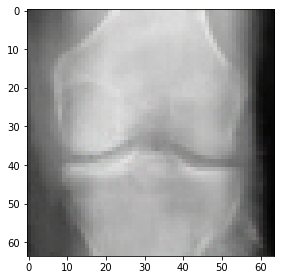

1 2


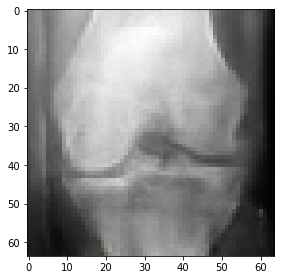

1 3


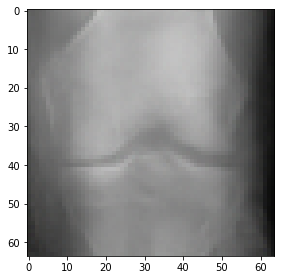

1 4


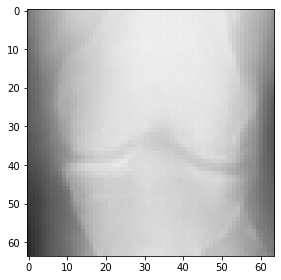

1 5


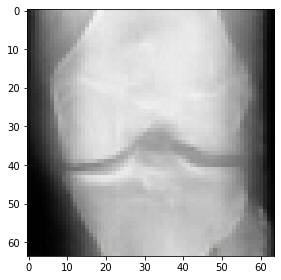

1 6


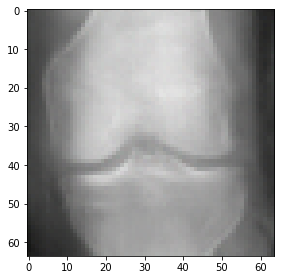

1 7


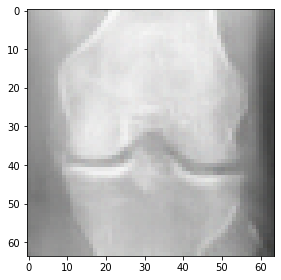

2 0


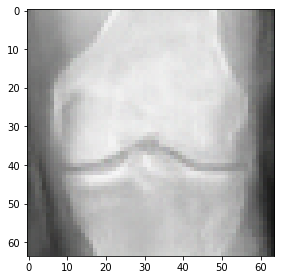

2 1


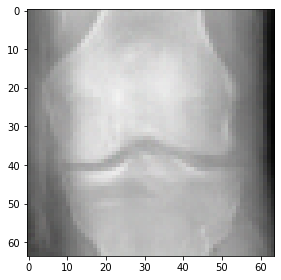

2 2


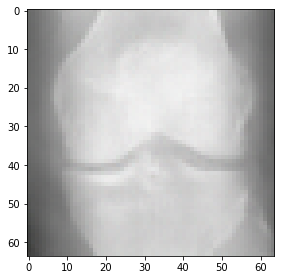

2 3


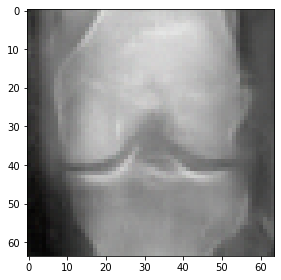

2 4


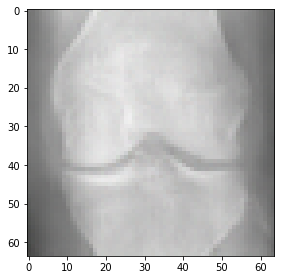

2 5


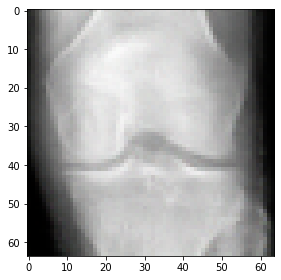

2 6


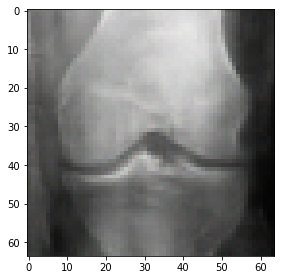

2 7


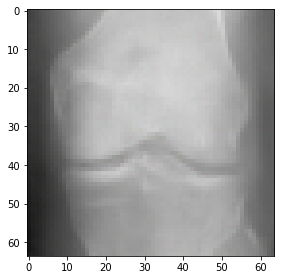

3 0


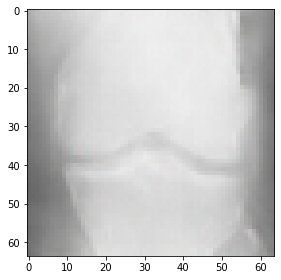

3 1


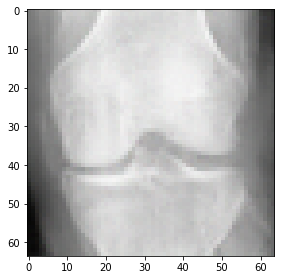

3 2


3 3


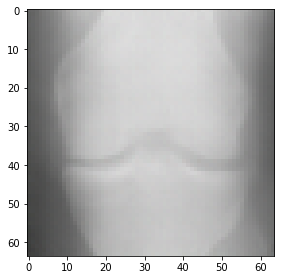

3 4


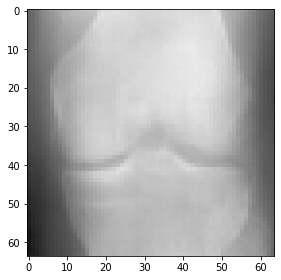

3 5


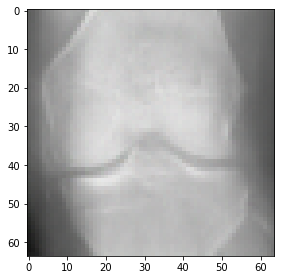

3 6


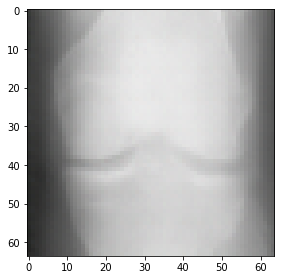

3 7


4 0


4 1


4 2


4 3


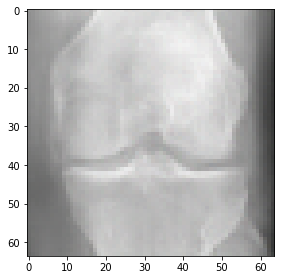

4 4


4 5


4 6


4 7


5 0


5 1


5 2


5 3


5 4


5 5


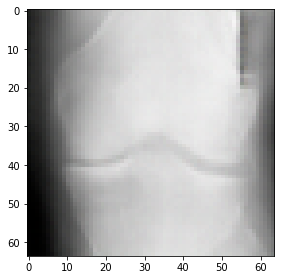

5 6


5 7


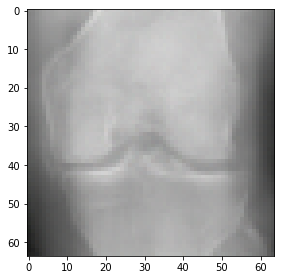

6 0


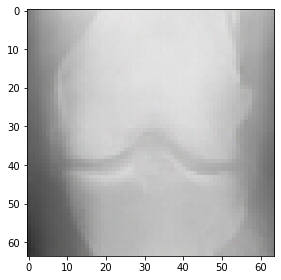

6 1


6 2


6 3


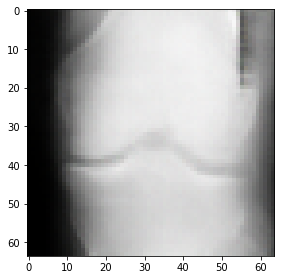

6 4


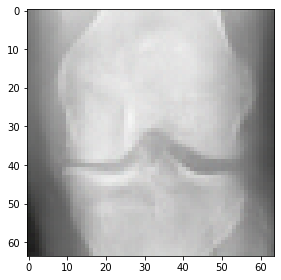

6 5


6 6


6 7


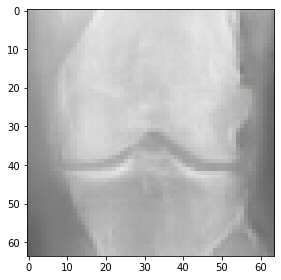

7 0


7 1


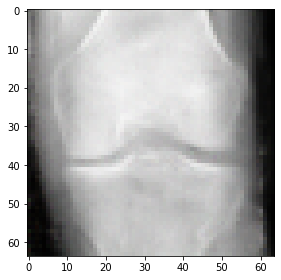

7 2


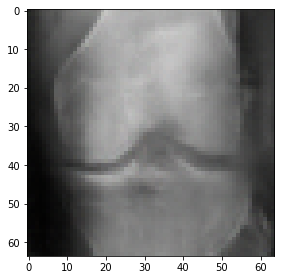

7 3


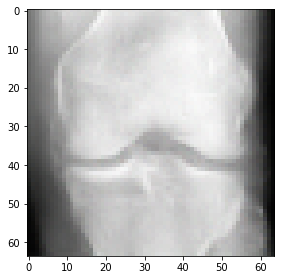

7 4


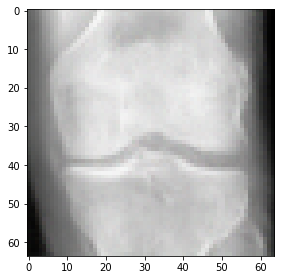

7 5


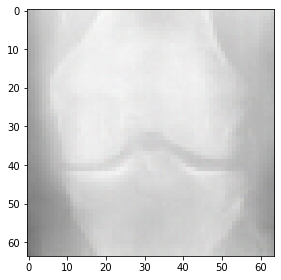

7 6


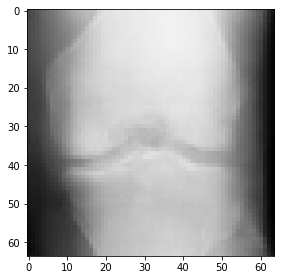

7 7


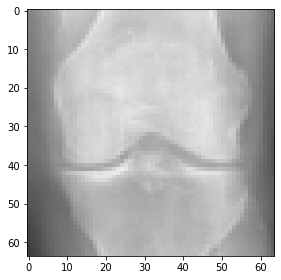

In [17]:

arr = np.asarray(img_fake)
arr = np.split(arr, 8)
arr = np.array([np.split(x, 8, 1) for x in arr])

from PIL import Image
n=1
for i in range(8):
    for j in range(8):
        print(i,j)
        img_array= arr[i][j]
        #print(img_array.shape)
        plt.imshow(img_array)
        plt.tight_layout()

        plt.savefig(f'./new_result/{grade}/fake_image{n}.png')
        plt.show()
        #im = Image.fromarray(img_array)
        #im.save(f'./result/fake_image{n}.png')
        n +=1 

import os
import zipfile
 
fantasy_zip = zipfile.ZipFile('archive.zip', 'w')
 
for folder, subfolders, files in os.walk('./result/'):
    for file in files:
        if file.endswith('.png'):
            fantasy_zip.write(os.path.join(folder, file), os.path.relpath(os.path.join(folder,file), './result/'), compress_type = zipfile.ZIP_DEFLATED)
fantasy_zip.close()